# BERT Prepositions

code to process sentences and corrections

In [1]:
import re
import time

start = time.time()

def correct_sentence(sentence, correction):
    
    sentence_list = sentence.split()
    correction_list = correction.split()
    
    sentence_list[int(correction_list[0]) - 1] = correction_list[3]
    
    return " ".join(sentence_list)

def masked_sentence(sentence, correction):
    
    sentence_list = sentence.split()
    correction_list = correction.split()
    
    sentence_list[int(correction_list[0]) - 1] = "[MASK]"
    
    return " ".join(sentence_list)

sentences_file = open('wikiprepdata/sentences.txt', 'r')
corrections_file = open('wikiprepdata/corrections.txt', 'r')

correct_sentences = []
incorrect_sentences = []

masked_sentences = []

corrections = []

sentence = sentences_file.readline()
correction = corrections_file.readline()

while sentence:

    if((correction.split()[3] != 'NULL') & (len(sentence) < 512)):

        sentence = re.sub(r'_[A-Z,.!?;:\'\`]*', '', sentence)
        
        correct_sentences.append(correct_sentence(sentence, correction))
        incorrect_sentences.append(sentence[:-2])

        masked_sentences.append(masked_sentence(sentence, correction))

        corrections.append(correction.split())

    sentence = sentences_file.readline()
    correction = corrections_file.readline()
    
end = time.time()
print(end - start)

12.857964038848877


In [2]:
from transformers import pipeline

start = time.time()

unmasker = pipeline('fill-mask', model='bert-base-uncased')

prediction_count = 5000

predictions = unmasker(masked_sentences[:prediction_count])

end = time.time()
print(end - start)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1484.9478290081024


$$ 
    \displaystyle \text{probability} =
        \begin{cases}
            p[\text{'score'}] & \text{if $\exists p \in P$} \\
            0 & \text{else} \\
        \end{cases}
$$

$$ P = \{ p_1 , \dots , p_5 \} , p_n = \text{dictionary containing {sequence, score, token, token_str}} $$

$$ \text{probabilities} $$

In [4]:
import numpy as np

incorrect_prepositions = [] # the list of uncorrected prepostions
correct_prepositions = [] # the list of 'corrected' prepositions

probabilities = []

for i in range(len(predictions)):
    
    incorrect_prep = corrections[i][1].lower() # incorrect
    correct_prep = corrections[i][3].lower() # correct
    
    incorrect_prob = 0
    correct_prob = 0
    
#     print(predictions[i])
    
#     print(incorrect_prep)
#     print(correct_prep)
    
    for j in range(len(predictions[i])):
        
        prep = predictions[i][j]['token_str']
        score = predictions[i][j]['score']
        
        if prep == incorrect_prep:
            
            incorrect_prob = score
            
        elif prep == correct_prep:
            
            correct_prob = score
            
    incorrect_prepositions.append(incorrect_prep)
    correct_prepositions.append(correct_prep)
    
    probabilities.append([incorrect_prob, correct_prob])

incorrect_prepositions = np.array(incorrect_prepositions)
correct_prepositions = np.array(correct_prepositions)

probabilities = np.array(probabilities)

np_corrections = np.char.lower(np.array(corrections))

### frequency of 'incorrect' and 'correct' prepositions

In [5]:
from collections import Counter

num_common = 10 # top X most common prepositions

def get_most_common(counter, num):
    
    return counter.most_common()[:num]

def get_frequency_list(preposition_list):
    
    size = preposition_list.size
    
    counter = Counter(preposition_list)
    most_common = get_most_common(counter, num_common)
    
    frequency = []
    
    for i in range(num_common):
        
        frequency.append((most_common[i][0], most_common[i][1]/size))
        
    return frequency

def get_frequency_list_from_common(most_common, size):
    
    frequency = []
    
    for i in range(num_common):
        
        frequency.append((most_common[i][0], most_common[i][1]/size))
        
    return frequency

def print_prepositions_and_frequency(preposition_list):
    
    size = preposition_list.size
    
    counter = Counter(preposition_list)
    most_common = get_most_common(counter, num_common)
    
    print("most common prepositions:")
    print(most_common)
    
    print('\nrelative frequency:')

    frequency = get_frequency_list_from_common(most_common, size)
    
    for i in range(num_common):
        print(frequency[i])
        
    print()

print("incorrect prepositions:\n")
print_prepositions_and_frequency(np_corrections[:,1])
print('---\n')
print("correct prepositions:\n")
print_prepositions_and_frequency(np_corrections[:,3])

incorrect prepositions:

most common prepositions:
[('in', 257650), ('of', 134758), ('on', 110082), ('to', 82859), ('for', 70221), ('at', 64518), ('from', 53011), ('with', 49350), ('by', 41340), ('as', 28961)]

relative frequency:
('in', 0.21647822320656634)
('of', 0.11322403416600221)
('on', 0.09249119257529687)
('to', 0.06961835473189552)
('for', 0.05899987312939373)
('at', 0.05420819718548903)
('from', 0.04453998482593941)
('with', 0.04146400277602969)
('by', 0.03473397922514827)
('as', 0.024333110119485225)

---

correct prepositions:

most common prepositions:
[('in', 205722), ('on', 129363), ('of', 124787), ('for', 74425), ('to', 70788), ('at', 68779), ('from', 67679), ('by', 49470), ('with', 47909), ('during', 33430)]

relative frequency:
('in', 0.17284817789443524)
('on', 0.1086911406507706)
('of', 0.10484637313905606)
('for', 0.06253208524024335)
('to', 0.059476268054905565)
('at', 0.05778830084969698)
('from', 0.056864077890150216)
('by', 0.04156482709888933)
('with', 0.04025

### BERT confidence of 'incorrect' and 'correct' prepositions

[0.169895   0.52598997] 

	 in
	 [0.23331733107046718, 0.641855467399573]
	 of
	 [0.24378476196203872, 0.6830769413545255]
	 on
	 [0.1700340802961166, 0.6881952337386099]
	 to
	 [0.18817883361986232, 0.6388391839163192]
	 for
	 [0.17018561828302983, 0.5207203438412398]
	 at
	 [0.1546551884356172, 0.5102522995497566]
	 from
	 [0.12092999588642335, 0.5368706441547891]
	 with
	 [0.15333766091313183, 0.4622223852657282]
	 by
	 [0.16090462762857202, 0.5581274262662875]
	 as
	 [0.10522945262061119, 0.5240970939248256]


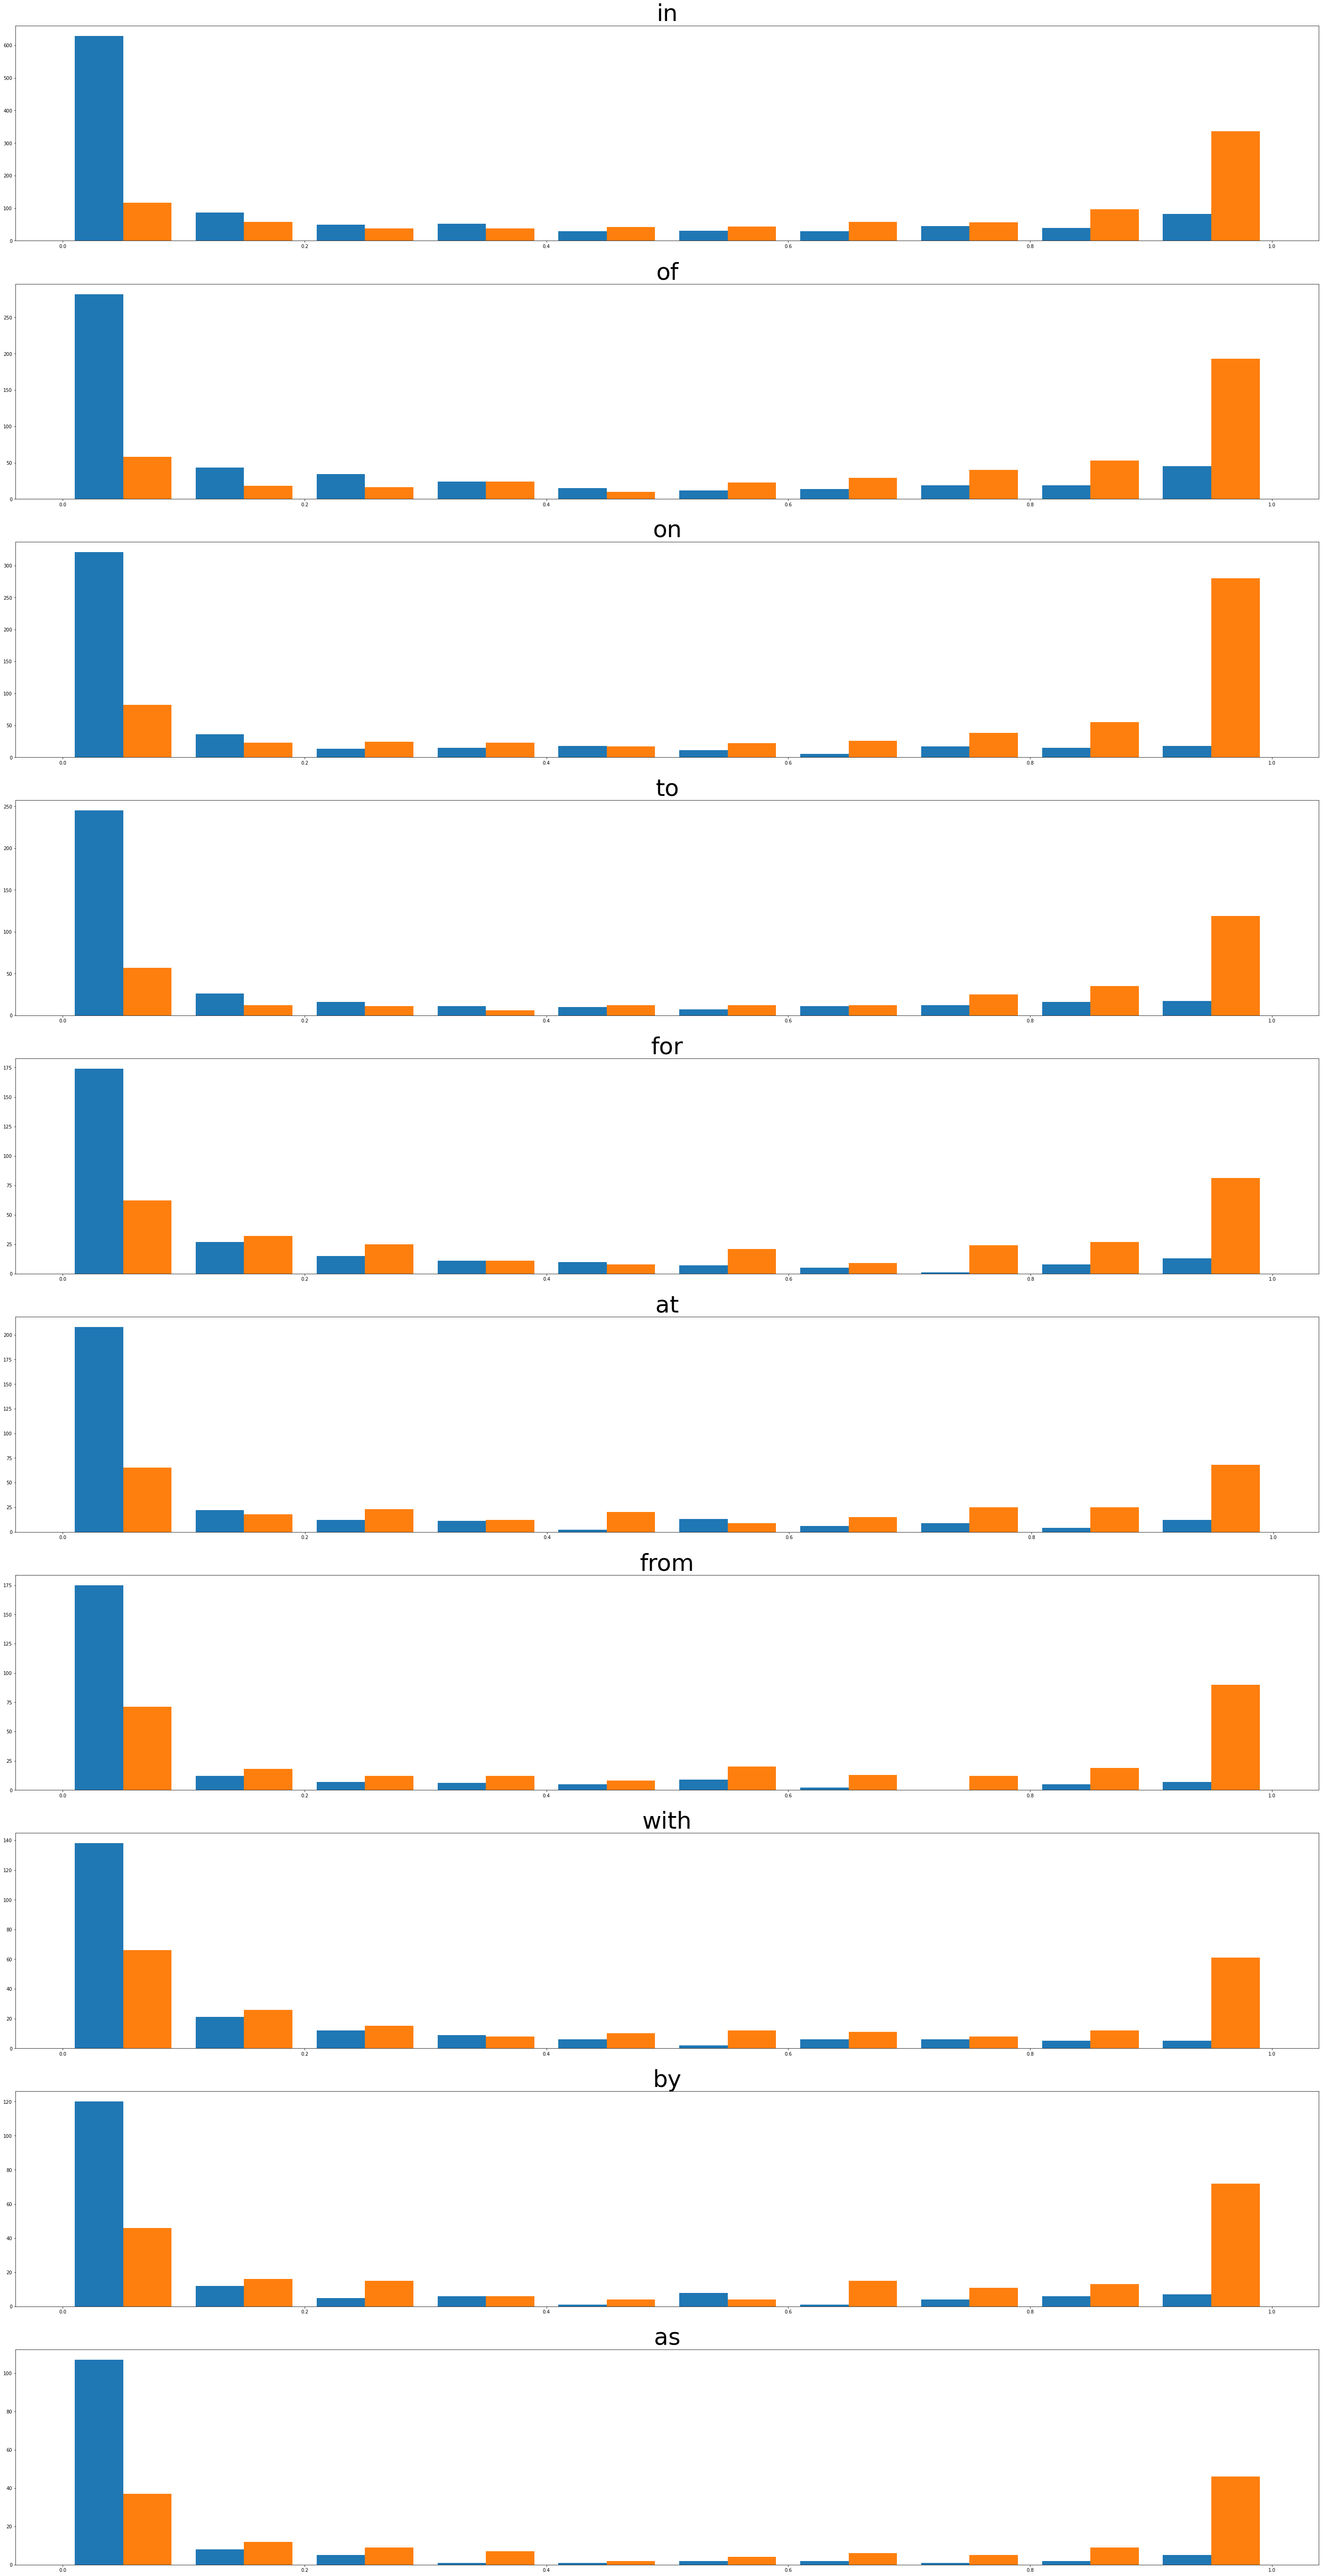

In [7]:
import matplotlib.pyplot as plt

print(np.mean(probabilities, axis=0),'\n')

def get_probs_for_incorrect_prep(preposition):
    
    incorrect_probabilities = probabilities[:,0]
    
    return incorrect_probabilities[incorrect_prepositions == preposition]

def get_probs_for_correct_prep(preposition):
    
    correct_probabilities = probabilities[:,1]
    
    return correct_probabilities[correct_prepositions == preposition]

def get_probs_for_prep(preposition):
    
    return [get_probs_for_incorrect_prep(preposition), get_probs_for_correct_prep(preposition)]

def get_mean_probs_for_prep(preposition):
    
    incorrect_mean = np.mean(get_probs_for_incorrect_prep(preposition))
    correct_mean = np.mean(get_probs_for_correct_prep(preposition))
    
    return [incorrect_mean, correct_mean]
    
prep_num = 10

counter = Counter(np_corrections[:,1])
most_common = get_most_common(counter, prep_num)

fig, axs = plt.subplots(10, figsize=(50,100))

for i in range(prep_num):
    
    print('\t',most_common[i][0])
    print('\t',get_mean_probs_for_prep(most_common[i][0]))
    
    axs[i].set_title(most_common[i][0], fontsize=50)
    
    axs[i].hist(get_probs_for_prep(most_common[i][0]), label=['incorrect', 'correct'])
    

In [8]:
correct_probabilities = probabilities[:,1]

indices = (correct_prepositions == 'in') & (correct_probabilities < 0.1)

original = np.array(incorrect_sentences)[:prediction_count][indices]
corrected = np.array(correct_sentences)[:prediction_count][indices]
specific_predictions = np.array(predictions)[indices]

for i in range(prediction_count):
    
    print('index: ', np.nonzero(indices)[0][i])
    print('original: ', original[i])
    print('corrected: ', corrected[i])
    print('prediction: ', specific_predictions[i])
    print()

index:  34
original:  The couple concentrated on distributing EMI classical recordings to the U.S . market .
corrected:  The couple concentrated on distributing EMI classical recordings in the U.S . market .
prediction:  [{'sequence': 'the couple concentrated on distributing emi classical recordings to the u. s. market.', 'score': 0.6937485337257385, 'token': 2000, 'token_str': 'to'}
 {'sequence': 'the couple concentrated on distributing emi classical recordings for the u. s. market.', 'score': 0.17934513092041016, 'token': 2005, 'token_str': 'for'}
 {'sequence': 'the couple concentrated on distributing emi classical recordings in the u. s. market.', 'score': 0.04934508353471756, 'token': 1999, 'token_str': 'in'}
 {'sequence': 'the couple concentrated on distributing emi classical recordings into the u. s. market.', 'score': 0.041134513914585114, 'token': 2046, 'token_str': 'into'}
 {'sequence': 'the couple concentrated on distributing emi classical recordings on the u. s. market.', 's

IndexError: index 117 is out of bounds for axis 0 with size 117

In [ ]:
incorrect_probabilities = probabilities[:,0]

indices = (incorrect_prepositions == 'in') & (incorrect_probabilities > 0.9)

original = np.array(incorrect_sentences)[:prediction_count][indices]
uncorrected = np.array(incorrect_sentences)[:prediction_count][indices]
specific_predictions = np.array(predictions)[indices]

for i in range(prediction_count):
    
    print('index: ', np.nonzero(indices)[0][i])
    print('original: ', original[i])
    print('corrected: ', uncorrected[i])
    print('prediction: ', specific_predictions[i])
    print()

In [ ]:
print(len(corrections))